# Tweet Disaster Classification 

In this project Tweets will be classified if they are disaster related or not using model like RNN (Recurrent Neural Network, LSTM, and GRU models. This is a binary classification problem hosted by kaggle and you can see the project with this link: https://www.kaggle.com/c/nlp-getting-started/overview. Our models will be rated on an F1 score. 

### The Data

train.csv: 7613 labeled tweets
test.csv: 1363 unlabeled tweets

In the training data it will contain the text of a tweet, a keyword from that tweet, and the location that tweet was sent from. 

The prediction will either be a 1 for yes or 0 for no. 

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import spacy
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import spacy
nlp = spacy.load("en_core_web_sm")


### Loading the Data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

train.head()
print(train.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


## Exploratory Data Analysis (EDA)

Lets first look at our data and see what we are working with. First though lets clean our data up. 

### Data Cleanup

In [3]:
print("Missing values in training data:\n", train.isnull().sum())

Missing values in training data:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


From the data you can see we are missing keywords and location data. This is fine for our model to run, so we will not clean up the data any further. 

It will also be good to lowercase all the text to make it easier for our models to work with. 

In [4]:
train['text'] = train['text'].str.lower()

### Exploring the Data

First lets see the distribution in our dataset. 

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


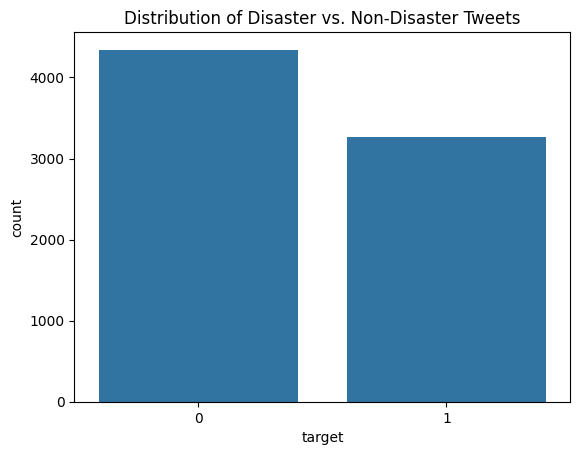

In [5]:
print(train['target'].value_counts(normalize=True))


sns.countplot(x='target', data=train)
plt.title("Distribution of Disaster vs. Non-Disaster Tweets")
plt.show()


As you can see from the data there are more Non-disaster tweets than disaster tweets. The distribution is 57% Non-disaster and 43% disaster. 

Now lets look at the average tweet length 

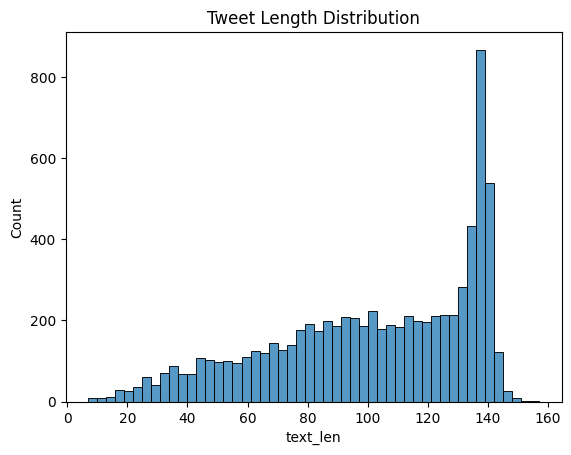

In [6]:
train['text_len'] = train['text'].apply(len)
sns.histplot(train['text_len'], bins=50)
plt.title("Tweet Length Distribution")
plt.show()


As you can see the average tweet size is roughly between 100-140 characters in length. 

In our dataset we know that there are keywords in most of the data set entries. So, lets see what the most common keywords are.

Text(0.5, 1.0, 'Top Keywords Most Associated with Disasters')

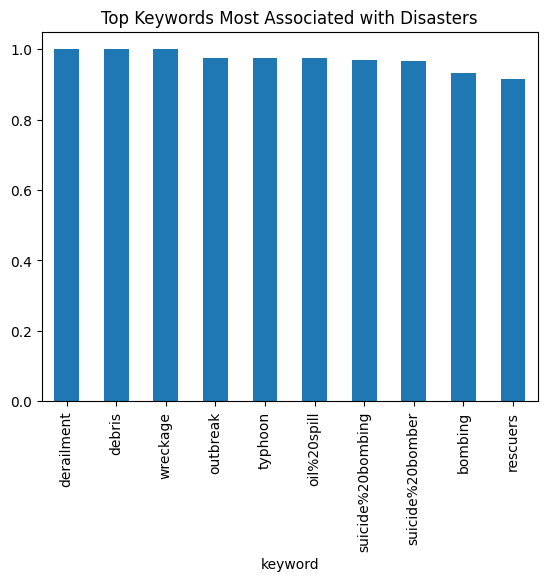

In [7]:
top_keywords = train.groupby('keyword')['target'].mean().sort_values(ascending=False).head(10)
top_keywords.plot(kind='bar')
plt.title("Top Keywords Most Associated with Disasters")


These are the most common words in the dataset. 

## Data Preprocessing

Before we train our models we need to get our data ready for processes and we do this through tokenization with our prepocessing pipeline:
1. Stopword Removal: Remove common words like ("the", "is", "at") using NLTK stopword list
2. lemmatization: Each word was reduced to its base form using SpaCy like ("Screaming" -> "Scream"
3. Punctuation removal: Remove all punctuation

   

In [8]:
stop_words = set(stopwords.words('english'))

def depunc(word):
    return ''.join([ch for ch in word if ch not in string.punctuation]).lower()

def clean_and_tokenize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    clean = [depunc(word) for word in lemmas if depunc(word) and word not in stop_words]
    return clean

train['tokens'] = train['text'].apply(clean_and_tokenize)
test['tokens'] = test['text'].apply(clean_and_tokenize)


Now lets convert the tweets into a numerical format that our models can read and use.  We use a tokenizer that buiilds a vocabulary and maps each word to an integer. Then each tweet is turned into a string of integers. The tweets are then padded which means the are turned into the same length to make sure the model has a consistent input size which helps with learning efficency. 

In [9]:
train, val = train_test_split(train, test_size=0.2)
max_sequence_length = 30


tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['text'])
vocab_size = len(tokenizer.word_index) + 1  


train_sequences = tokenizer.texts_to_sequences(train['text'])
val_sequences = tokenizer.texts_to_sequences(val['text'])

train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_sequence_length, padding='post')


## Model Architecture

In this project we will be comparing two different model architectures:

Simple RNN Model:
    - Embedding layering 
    - SimpleRNN (100 units)
    - Dense sigmoid output

LSTM (Long Short-Term Memory networks):
    - Embedding layer
    - LSTM (100 units)
    - Dense sigmoid output 

On both the loss function was binary_crossentropy with a Adam optimizer.

I chose these two models because Simple RNN is the most basic model for recurrent neural networks. So, I thought it would be a good baseline to test LSTM against. I then chose LSTM because it is a better RNN that helps with gradient problems and they are very common to use in most NLP problems. 
 

### RNN Model

The first model we will test is a simple RNN model. 

C:\Users\Grant\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6789 - loss: 0.6014 - val_accuracy: 0.7965 - val_loss: 0.4772
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9019 - loss: 0.2675 - val_accuracy: 0.7814 - val_loss: 0.5643
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9750 - loss: 0.0826 - val_accuracy: 0.7787 - val_loss: 0.7149
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9827 - loss: 0.0470 - val_accuracy: 0.7485 - val_loss: 0.7388
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9914 - loss: 0.0254 - val_accuracy: 0.7170 - val_loss: 0.8321
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9882 - loss: 0.0343 - val_accuracy: 0.7255 - val_loss: 0.8177
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9932 - loss: 0.0191 - val_accuracy: 0.7728 - val_loss: 0.9009
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9913 - loss: 0.0243 - val_accu

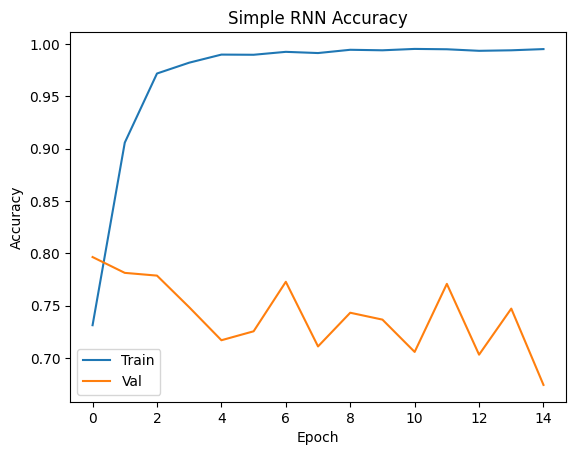

In [10]:
embedding_dim = 100
rnn_units = 100
epochs = 15
histories = {}

model_rnn = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
    SimpleRNN(rnn_units),
    Dense(1, activation='sigmoid')
])
model_rnn.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history_rnn = model_rnn.fit(train_padded, train['target'], validation_data=(val_padded, val['target']), epochs=epochs)
histories['Simple RNN'] = history_rnn


plt.plot(history_rnn.history['accuracy'], label='Train')
plt.plot(history_rnn.history['val_accuracy'], label='Val')
plt.title('Simple RNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

As you can see from the RNN model we get an accuracy of roughly 0.7. Which is alright but could be better, so lets look at the LSTM model.

### LSTM Model 

LSTM is a better model than RNN and it should prove to have a higher accuracy. 

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6513 - loss: 0.6153 - val_accuracy: 0.7984 - val_loss: 0.4655
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8972 - loss: 0.2765 - val_accuracy: 0.7925 - val_loss: 0.4943
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9516 - loss: 0.1573 - val_accuracy: 0.7722 - val_loss: 0.6232
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9728 - loss: 0.0880 - val_accuracy: 0.7689 - val_loss: 0.8107
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9842 - loss: 0.0508 - val_accuracy: 0.7492 - val_loss: 0.8717
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9816 - loss: 0.0673 - val_accuracy: 0.7557 - val_loss: 1.0371
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9865 - loss: 0.0354 - val_accuracy: 0.7603 - val_loss: 1.1345
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9951 - loss: 0.0153 - val_accu

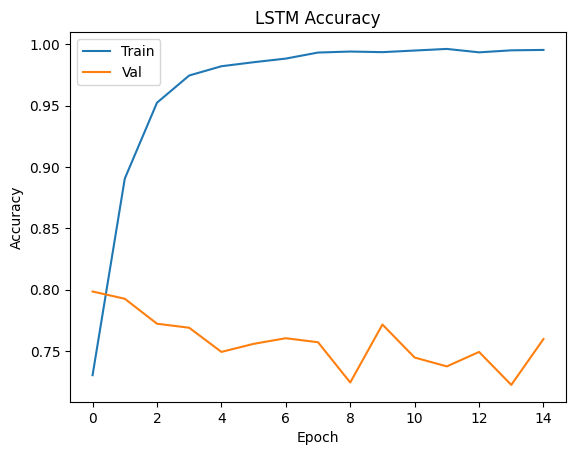

In [11]:

model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_sequence_length),
    LSTM(rnn_units),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history_lstm = model_lstm.fit(train_padded, train['target'], validation_data=(val_padded, val['target']), epochs=epochs)
histories['LSTM'] = history_lstm

plt.plot(history_lstm.history['accuracy'], label='Train')
plt.plot(history_lstm.history['val_accuracy'], label='Val')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


From this we can see that LSTM has an accuracy of roughly between 0.70-0.75 which is slightly higher than the RNN model. Lets do a little more optimization to make it better.

### Hyperparameter Optimization 

To improve perrfomance and reduce overfitting we added some tuning to the LSTM model. In this new model we introduced a dropout layer to help improve generalization.

In [12]:
model_lstm_opt = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    LSTM(rnn_units, return_sequences=False),
    Dropout(0.4),  
    Dense(1, activation='sigmoid')
])

model_lstm_opt.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])


history_lstm_opt = model_lstm_opt.fit(
    train_padded, train['target'],
    validation_data=(val_padded, val['target']),
    epochs=15,
    batch_size=64,
    verbose=1
)

Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6354 - loss: 0.6323 - val_accuracy: 0.7978 - val_loss: 0.4533
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8840 - loss: 0.3042 - val_accuracy: 0.7965 - val_loss: 0.5108
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9506 - loss: 0.1443 - val_accuracy: 0.7754 - val_loss: 0.6390
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9790 - loss: 0.0680 - val_accuracy: 0.7045 - val_loss: 1.0831
Epoch 5/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9743 - loss: 0.0803 - val_accuracy: 0.7702 - val_loss: 0.9139
Epoch 6/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9890 - loss: 0.0371 - val_accuracy: 0.7630 - val_loss: 1.2004
Epoch 7/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9939 - loss: 0.0225 - val_accuracy: 0.7492 - val_loss: 1.3853
Epoch 8/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9953 - loss: 0.0148 - val_accuracy: 0.7708 - v

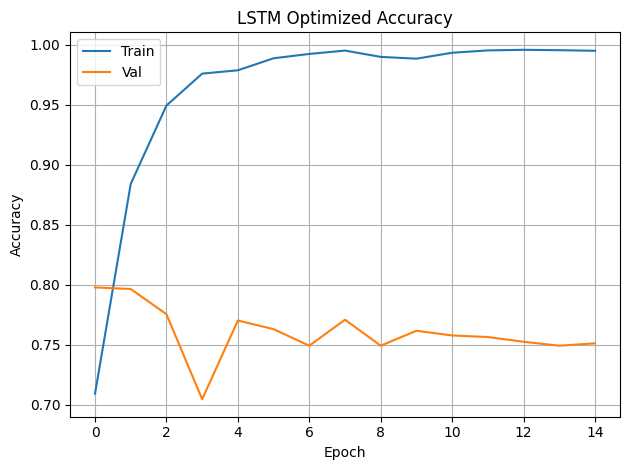

In [13]:
plt.plot(history_lstm_opt.history['accuracy'], label='Train')
plt.plot(history_lstm_opt.history['val_accuracy'], label='Val')

plt.title('LSTM Optimized Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The results show that the overall accuracy is slightly higher in the optimized version. Lets compare the two side by side. 

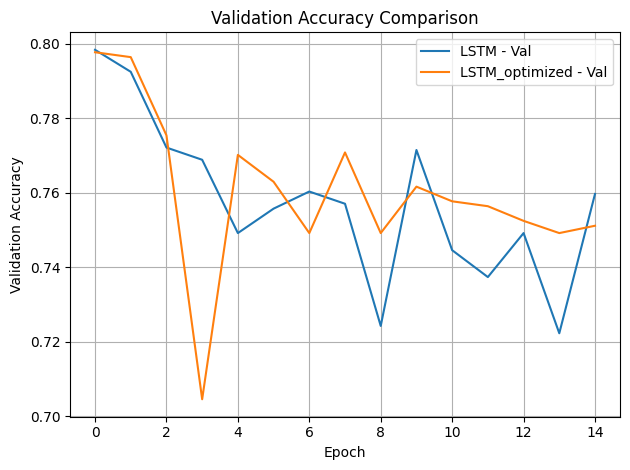

In [14]:
plt.plot(history_lstm.history['val_accuracy'], label='LSTM - Val')
plt.plot(history_lstm_opt.history['val_accuracy'], label='LSTM_optimized - Val')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

As you can see the results are extremely similar but it seems like the optimized version starts off with a slightly higher accruacy, but it also is less choppy as you increase epochs compared to the normal LSTM model. 

## Results and Analysis

Three different models were testing in this project RNN, LSTM, and an optimized LSTM. The RNN model had a peak accuracy of about 75% but it greatly decreased with each epoch. The LSTM model outperformed RNN and had a peak accuracy of about 81%. The optimized LSTM model with a dropout layer increased this peak accuracy to about 81% which wasnt as good as I thought it would help, but it also had a more stable accuracy with each epoch increase compared to the unoptimized model. Below you can see a graph of the accuracy by epoch for each model. 

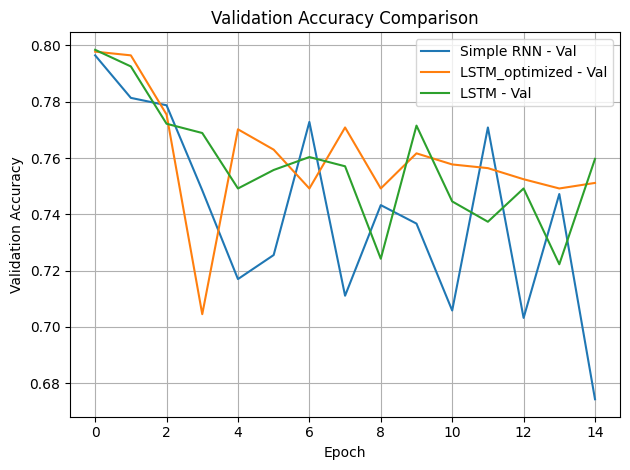

In [15]:

plt.plot(history_rnn.history['val_accuracy'], label='Simple RNN - Val')
plt.plot(history_lstm_opt.history['val_accuracy'], label='LSTM_optimized - Val')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM - Val')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Conclusion

This project created 3 different neural network model to classify disaster tweets. We initially tested a simple RNN model and then a simple LSTM model and later an optimized lSTM model. Overall the RNN model performed the worst. The LSTM model showed the second best results while the optimized LSTM model had the best accuracy at classifying disaster tweets. In the future it would be good add addtional parameters to further tune the model to increase the results like addition better text preprocessing. Overall the project was a sucess and we were able to effectively classify disaster tweets. 